In [1]:
%load_ext autoreload
%autoreload 2 

from utils.data_download import download_data_with_animation, unzip_data
from utils.read_tensorflow_data import read_tf_data, data_type, create_tf_dataset
from utils.plotting import plot_histories 
import os
from typing import List, Tuple, TypedDict, Dict
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from keras.models import Sequential
from keras import layers, models
from keras.callbacks import ModelCheckpoint
from keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    concatenate,
    Dropout,
    Dense,
    Flatten,
    BatchNormalization,
    Activation,
    AveragePooling2D,
    Add,
    Dropout,
    MaxPool2D,
    GlobalAveragePooling2D,
)
import tensorflow as tf
from keras.models import Sequential, Model, load_model
from keras.metrics import Recall
from keras.metrics import Precision

2024-05-13 01:11:55.324657: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-13 01:11:55.988794: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Download data


In [2]:
# data will only be downloaed when the output file does not exist. In this case the file is ./data/data.zip
# if there is any issues remove everything under ./data and run the code again
url = "https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F27069%2F46974%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240422%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240422T195446Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D27f3460b8b1512fc77d5fa919e5f7471c55fe552037869b78d43ddb33f80831a03ed39077650fd90b858ed2f101d2f468053a7199462f3513d0b8dcc100674f5469a5c0a008151acc0041a3bc7074be4d33b2d65462aa5f4e6988f27c8e89737c60fe8dfc0a245cd3915303c5e4488db745aafae9a1a4e6caf34a0000fed7eec3d0a6723983064916e2e2993cc94612de815d32cc9d345622158e7569c4cc0d541cb2b5d0d705461e3821e7c881248dc22390f1a2fed45f2794a442fd3bbb4d727151d4eb5390f37b3a1d167facb8ea5c5b8b79a054e93e90371a96b2c1e3be8549bd09c9a37278fcfeb38aba093157906271145184ddc0f32799f1013733631"
download_data_with_animation(url, "./data/data.zip")
unzip_data("./data/data.zip", "./data/unzipped_data/")

./data/data.zip already exists, skipping download.
./data/unzipped_data/ already exists, skipping unzip.


In [3]:
data_files = [] 
for root, dirs, files in os.walk("./data/unzipped_data/") :
	for file in files:
		data_files.append( os.path.join(root, file).replace('\\', '/') )
  
data_files


['./data/unzipped_data/cv10_labels.npy',
 './data/unzipped_data/test10_labels.npy',
 './data/unzipped_data/cv10_data/cv10_data.npy',
 './data/unzipped_data/test10_data/test10_data.npy',
 './data/unzipped_data/training10_0/training10_0.tfrecords',
 './data/unzipped_data/training10_1/training10_1.tfrecords',
 './data/unzipped_data/training10_2/training10_2.tfrecords',
 './data/unzipped_data/training10_3/training10_3.tfrecords',
 './data/unzipped_data/training10_4/training10_4.tfrecords']

In [4]:
training_files = [file for file in data_files if "training" in file]
training_files

['./data/unzipped_data/training10_0/training10_0.tfrecords',
 './data/unzipped_data/training10_1/training10_1.tfrecords',
 './data/unzipped_data/training10_2/training10_2.tfrecords',
 './data/unzipped_data/training10_3/training10_3.tfrecords',
 './data/unzipped_data/training10_4/training10_4.tfrecords']

# Loading training data
Read the data from the training files 

The training data is being given in tfrecords (tensorflow files). need to convert it to numpy arrays ( The function is created under utils)


In [5]:
training_data :data_type = {"label": [], "data": []}   

for training_file in training_files:
	read_tf_data( training_file, training_data )

2024-05-13 01:12:02.686558: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-13 01:12:02.788376: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-13 01:12:02.788421: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-13 01:12:02.849930: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-13 01:12:02.849982: I external/local_xla/xla/stream_executor

# Data Visualization 

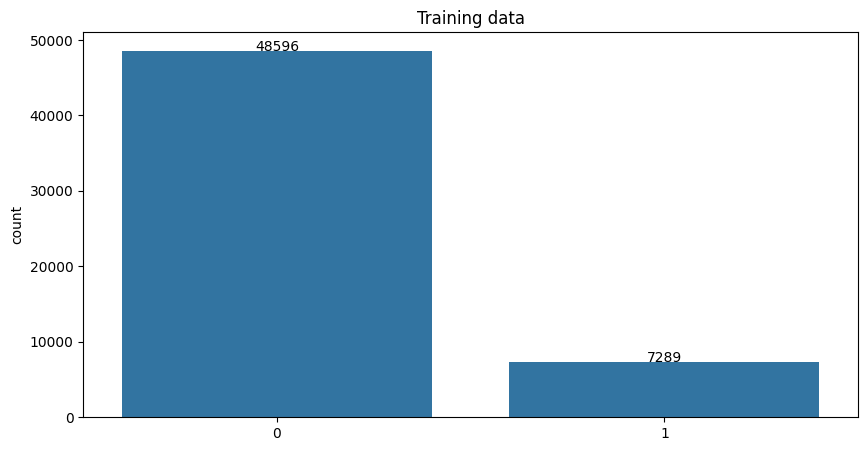

In [6]:
plt.figure(figsize=(10, 5))

sns.countplot(x=training_data['label'])
plt.title("Training data")
# add labels on top of the data 
# add labels on top of the data( note there is only 2 cathegories 1, 0) 
for i in range(2):
	plt.text(i, training_data['label'].count(i), training_data['label'].count(i), ha = 'center')  # type: ignore
plt.show()


# Data augmentation
Handling imbalanced datasets

In [7]:
def augment(image): 
    with tf.device("/CPU:0"):  
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.image.random_brightness(image, max_delta=0.1)
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
        # image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))  # Randomly rotate the image
        image = tf.image.random_jpeg_quality(image, min_jpeg_quality=80, max_jpeg_quality=100)
        return image
    
augmented_images = []
augmented_labels = []

for label, image in zip(training_data["label"], training_data["data"]):
    if label == 1:
        augmented_image1 = augment(image)
        augmented_images.append(augmented_image1)
        augmented_labels.append(label)


training_data["label"].extend(augmented_labels)
training_data["data"].extend(augmented_images)

In [8]:
import random

def shuffle(data_labels:data_type):
    # Create a list of indices from 0 to the length of data
    indices = list(range(len(data_labels['data'])))

    # Shuffle the indices
    random.shuffle(indices)

    # Use the shuffled indices to reorder data and labels
    shuffled_data = [data_labels['data'][i] for i in indices]
    shuffled_labels = [data_labels["label"][i] for i in indices]

    return shuffled_data, shuffled_labels

training_data['data'], training_data["label"] = shuffle(training_data)
training_data['data'], training_data["label"] = shuffle(training_data)

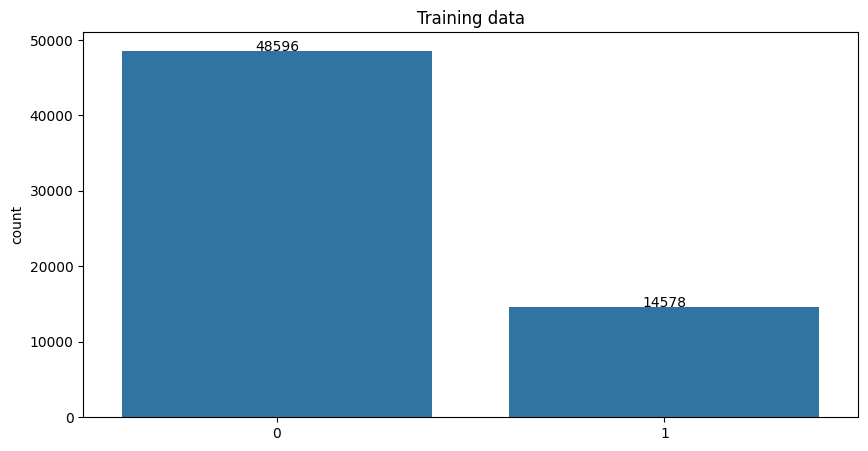

In [9]:
plt.figure(figsize=(10, 5))

sns.countplot(x=training_data['label'])
plt.title("Training data")
# add labels on top of the data 
# add labels on top of the data( note there is only 2 cathegories 1, 0) 
for i in range(2):
	plt.text(i, training_data['label'].count(i), training_data['label'].count(i), ha = 'center')  # type: ignore
plt.show()


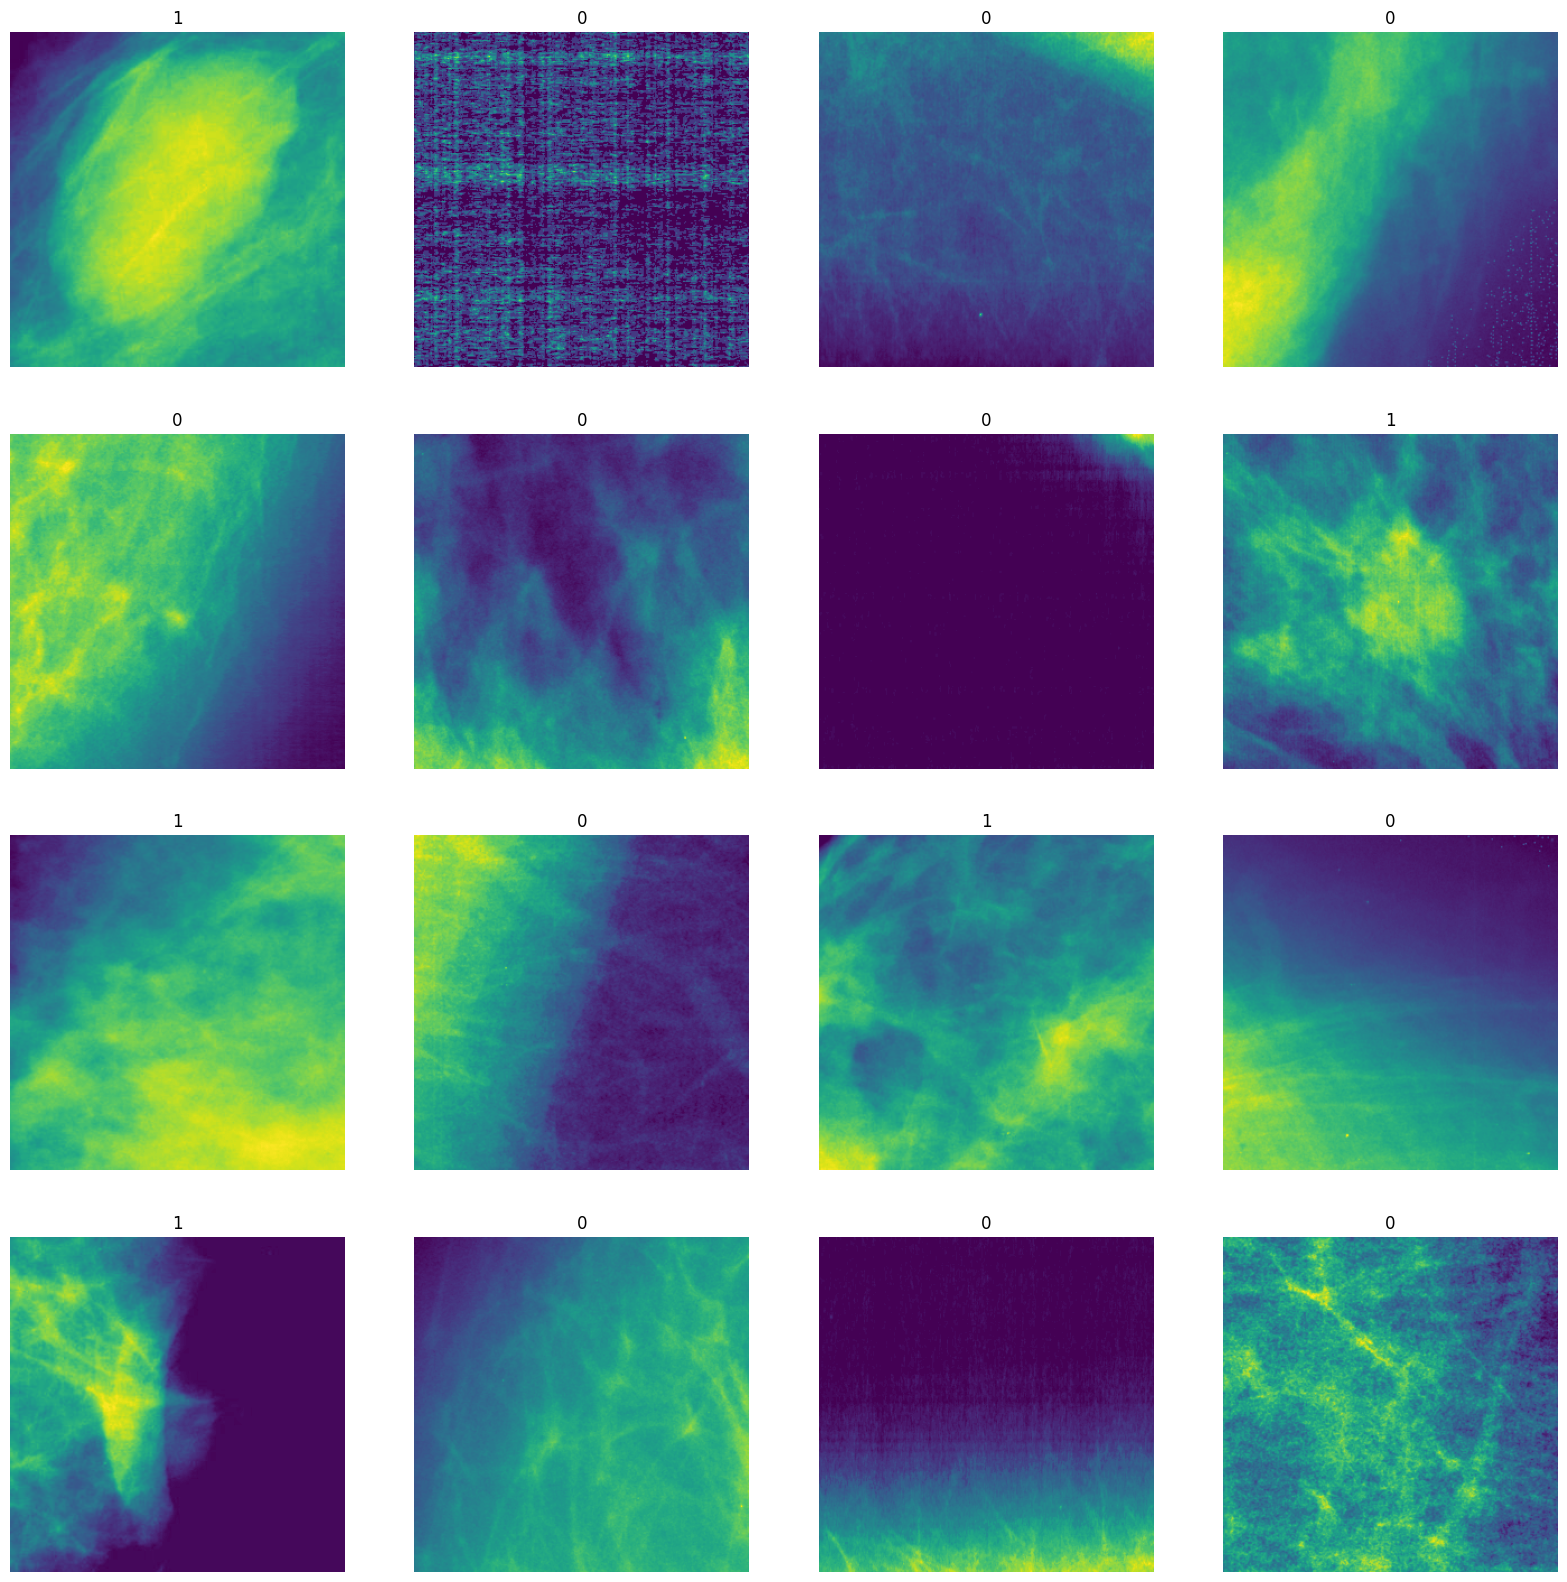

In [10]:
nrows = 4
ncols = 4

plt.figure(figsize=(20, 20))
for i in range(nrows*ncols):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(training_data["data"][i], )
    plt.title(str(training_data["label"][i]))
    # Remove the axis
    plt.axis('off')

# Show the plot
# plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.show()

# Loaing test data

In [11]:
test_files =  './data/unzipped_data/test10_data/test10_data.npy'
test_files_labels =  './data/unzipped_data/test10_labels.npy'

cross_validation_files =  './data/unzipped_data/cv10_data/cv10_data.npy'
cross_validation_files_labels = './data/unzipped_data/cv10_labels.npy'



# Note this data is ng, cv_data only contains masses, test_data only contains calcifications. 
test_data_ng = np.load( test_files)
test_data_labels = np.load(  test_files_labels) 
cv_data_ng = np.load( cross_validation_files)
cv_data_labels = np.load( cross_validation_files_labels)


# Fixing cv_data and test_data 
The data from CV only contains only calcifications and test files only contain masses.  

"**Note** - The data has been separated into training and test as per the division in the CBIS-DDSM dataset. The test files have been divided equally into test and validation data. However the split between test and validation data was done incorrectly, resulted in the test numpy files containing only masses and the validation files containing only calcifications. These files should be combined in order to have balanced and complete test data.
"

In [12]:
# 
cv_data : data_type = {'data': [], 'label': []}
test_data : data_type = {'data': [], 'label': []}
n_test = []  # data, label 
n_cv = [] # data, label 
for i in range( len(cv_data_ng)):
	if i%2: # odd 	
		n_test.append(   (cv_data_ng[i], cv_data_labels[i])   )
		n_test.append(   (test_data_ng[i], test_data_labels[i])   )
	else:
		n_cv.append(   (cv_data_ng[i], cv_data_labels[i])   )
		n_cv.append(   (test_data_ng[i], test_data_labels[i])   )

cv_data['data'] = [x[0] for x in n_cv]
cv_data['label'] = [np.int8(1) if x[1]>0 else np.int8(0) for x in n_cv]

test_data['data'] = [x[0] for x in n_test]
test_data['label'] = [np.int8(1) if x[1]>0 else np.int8(0) for x in n_test]

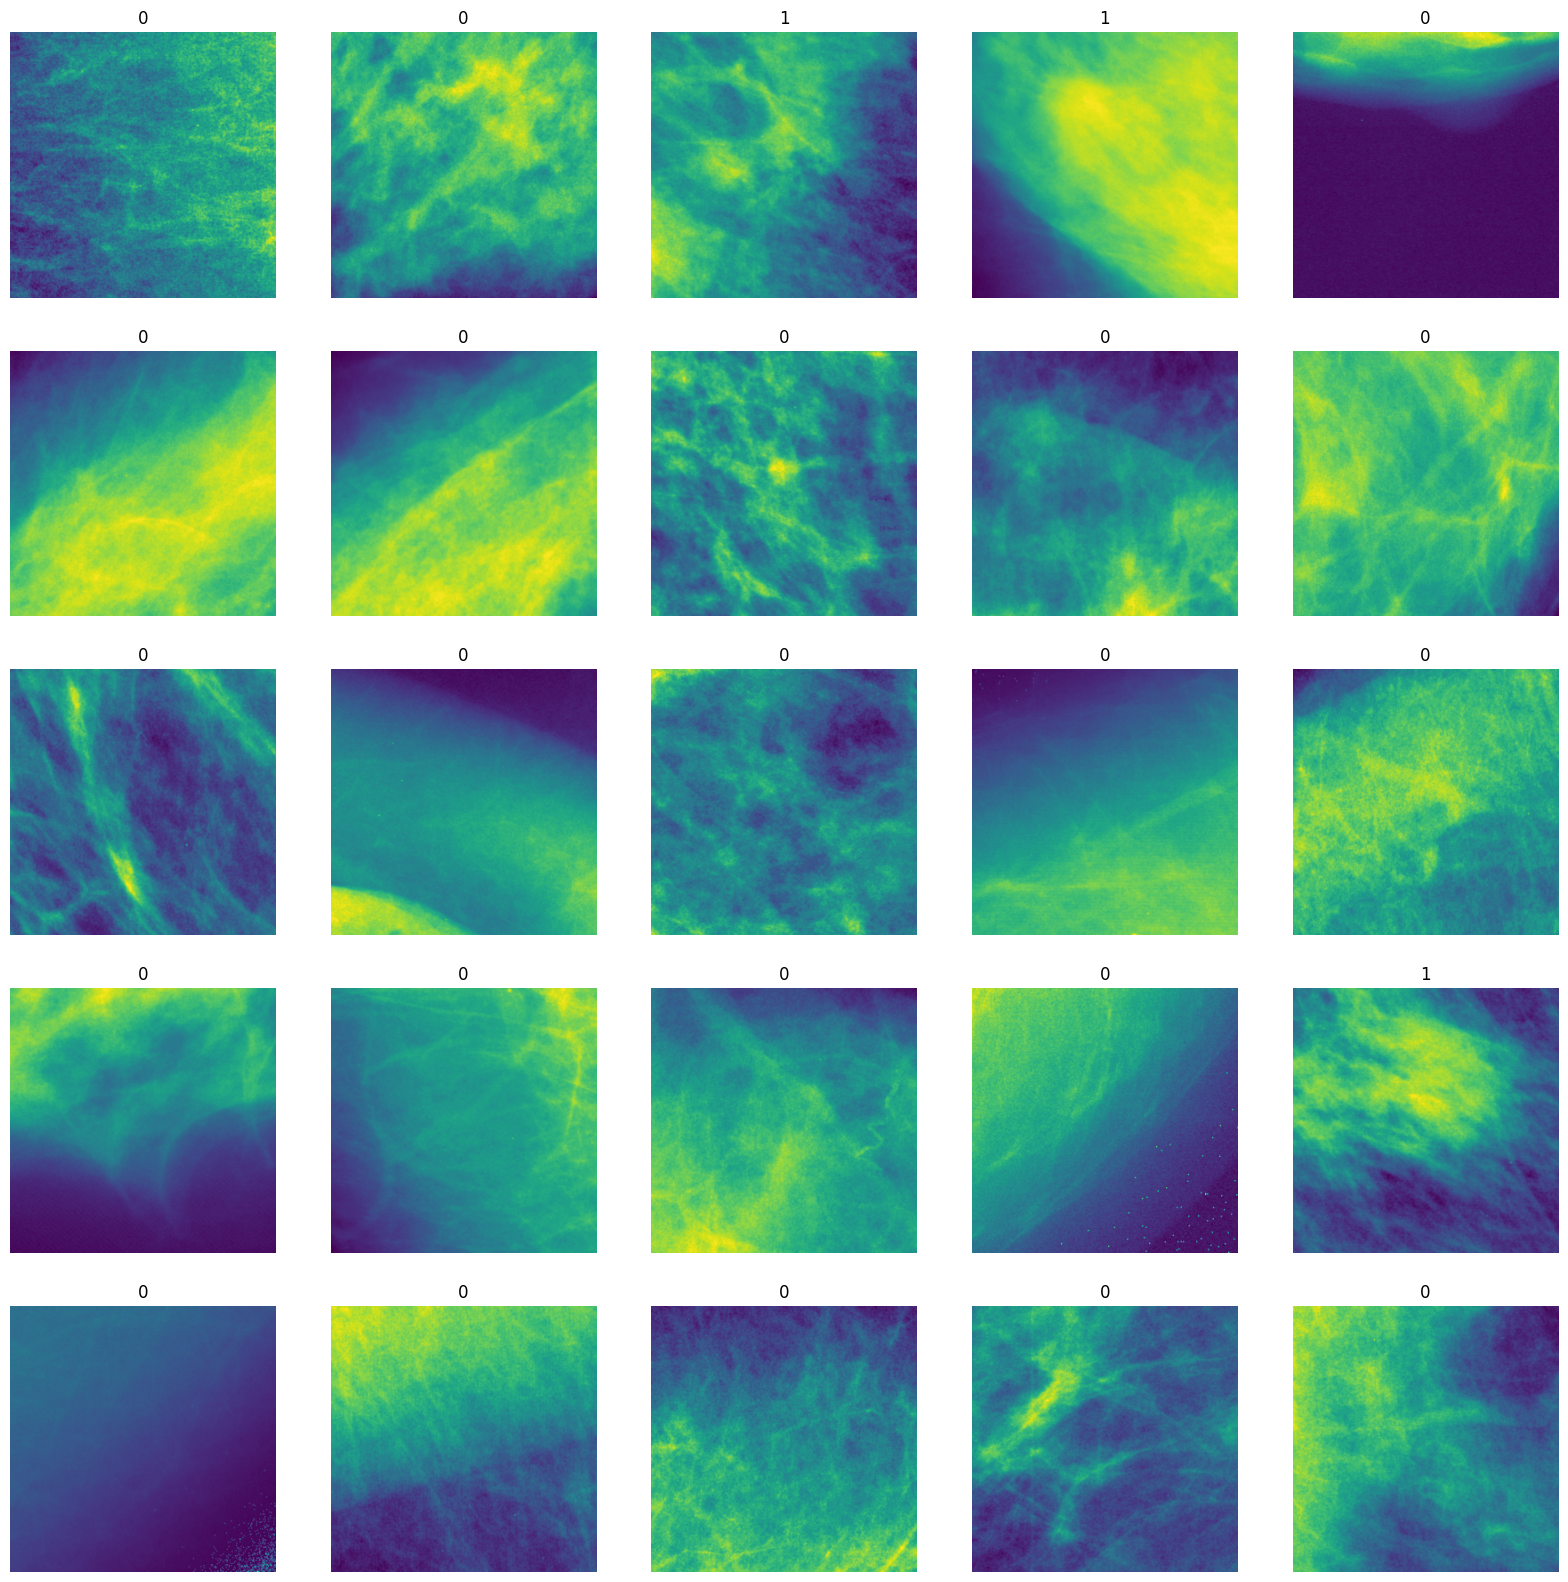

In [13]:
nrows = 5
ncols = 5

plt.figure(figsize=(20, 20))
for i in range(nrows*ncols):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(cv_data["data"][i], )
    plt.title(str(cv_data["label"][i]))
    # Remove the axis
    plt.axis('off')

plt.show()

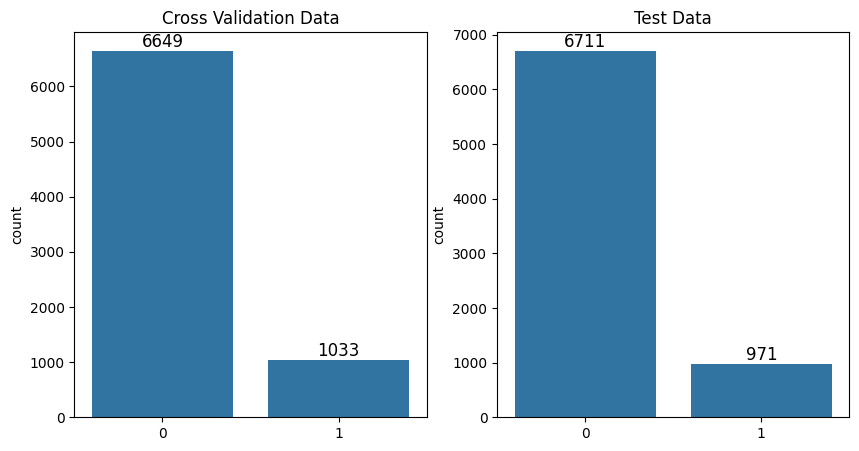

In [14]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
ax1 = sns.countplot(x=cv_data['label'])
plt.title("Cross Validation Data")
for p in ax1.patches:
    ax1.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()),  # type: ignore
            fontsize=12, ha='center', va='bottom')

plt.subplot(1, 2, 2)
plt.title("Test Data")
ax2 = sns.countplot(x=test_data['label'])
for p in ax2.patches:
    ax2.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()),  # type: ignore
            fontsize=12, ha='center', va='bottom')

plt.show()

In [15]:
len(training_data['data'])

63174

In [16]:
train_dataset = create_tf_dataset(training_data).batch(32) # DatasetV2

In [17]:
cv_dataset = create_tf_dataset( cv_data).batch(32) # DatasetV2

In [18]:
# Find the weights for each class  
ones = 0 
zeros = 0 
for label in training_data['label']:
	if label == 1:
		ones += 1
	else:
		zeros += 1

total = ones + zeros

weights_dict = {0: (1/zeros) * (total/2), 1: (1/ones) * (total/2)}
weights_dict
# {0: 0.6499917688698658, 1: 2.1667581286870625}

{0: 0.6499917688698658, 1: 2.1667581286870625}

# Testing Googles Model 
### Inception V1

In [19]:
# google 
def inception_module(x, filters):
    branch1x1 = layers.Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)

    branch3x3 = layers.Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    branch3x3 = layers.Conv2D(filters[2], (3, 3), padding='same', activation='relu')(branch3x3)

    branch5x5 = layers.Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    branch5x5 = layers.Conv2D(filters[4], (5, 5), padding='same', activation='relu')(branch5x5)

    branch_pool = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = layers.Conv2D(filters[5], (1, 1), padding='same', activation='relu')(branch_pool)

    # Concatenate all the branches
    output = layers.concatenate([branch1x1, branch3x3, branch5x5, branch_pool], axis=-1)
    return output

def create_googlenet_v1()->Model:
    # Functional API style of creating a model
    
    input_layer = layers.Input(shape=(299, 299, 1))

    # Initial Convolution and MaxPooling layers
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = inception_module(x, [64, 96, 128, 16, 32, 32])  # Inception module 1
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = inception_module(x, [128, 128, 192, 32, 96, 64]) # Inception module 2
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = inception_module(x, [192, 96, 208, 16, 48, 64])  # Inception module 3
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(1, activation='sigmoid')(x)  # Use sigmoid activation for binary classification

    model = Model(inputs=input_layer, outputs=x)
    return model


In [20]:
model_g = create_googlenet_v1()
model_g.summary()

model_g.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Recall(name='recall'), Precision(name='precision')])
best_val_recall_checkpoint = ModelCheckpoint('./v1_best_val_recall_checkpoint.keras', monitor='val_recall', save_best_only=True)
best_val_loss_checkpoint = ModelCheckpoint('./v1_best_val_loss_checkpoint.keras', monitor='val_loss', save_best_only=True)
history_g = model_g.fit(train_dataset, validation_data=cv_dataset, epochs=50, callbacks=[best_val_recall_checkpoint, best_val_loss_checkpoint], class_weight=weights_dict)
model_g.save('model_g.keras')

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 150, 150,  │      3,200 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 75, 75,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 75, 75,    │        256 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 75, 75,    │      6,240 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 75, 75,    │      1,040 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 75, 75,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 75, 75,    │      4,160 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 75, 75,    │    110,720 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 75, 75,    │     12,832 │ conv2d_4[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 75, 75,    │      2,080 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 75, 75,    │          0 │ conv2d_1[0][0],   │
│ (Concatenate)       │ 256)              │            │ conv2d_3[0][0],   │
│                     │                   │            │ conv2d_5[0][0],   │
│                     │                   │            │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 38, 38,    │          0 │ concatenate[0][0] │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 38, 38,    │     32,896 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 38, 38,    │      8,224 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 38, 38,    │          0 │ max_pooling2d_2[… │
│ (MaxPooling2D)      │ 256)              │            │                 

 Total params: 905,953 (3.46 MB)

 Trainable params: 905,825 (3.46 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/50


I0000 00:00:1715449610.144780  781485 service.cc:145] XLA service 0x7f265001fc40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715449610.145053  781485 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-05-11 17:46:50.388889: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-11 17:46:50.987949: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:1715449626.395065  781485 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


   1975/Unknown 173s 76ms/step - accuracy: 0.7314 - loss: 0.5148 - precision: 0.4524 - recall: 0.7931

I0000 00:00:1715449776.583873  781483 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_12', 116 bytes spill stores, 80 bytes spill loads

2024-05-11 17:49:36.673565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 17:49:36.673656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-05-11 17:49:44.636193: W tensorflow/core/framework/local_rendezvous.cc:404] Local r

1975/1975 ━━━━━━━━━━━━━━━━━━━━ 181s 80ms/step - accuracy: 0.7314 - loss: 0.5148 - precision: 0.4524 - recall: 0.7931 - val_accuracy: 0.8649 - val_loss: 0.7057 - val_precision: 0.4806 - val_recall: 0.0600
Epoch 2/50
1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7885 - loss: 0.4078 - precision: 0.5249 - recall: 0.8642

2024-05-11 17:52:05.884530: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 17:52:05.884654: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 146s 74ms/step - accuracy: 0.7885 - loss: 0.4077 - precision: 0.5249 - recall: 0.8642 - val_accuracy: 0.8821 - val_loss: 0.3507 - val_precision: 0.7213 - val_recall: 0.2004
Epoch 3/50


2024-05-11 17:52:10.823404: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 17:52:10.823507: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-11 17:52:10.823553: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10136814832244790557


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8008 - loss: 0.3820 - precision: 0.5422 - recall: 0.8734

2024-05-11 17:54:32.459488: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 17:54:32.459854: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 146s 74ms/step - accuracy: 0.8008 - loss: 0.3820 - precision: 0.5422 - recall: 0.8734 - val_accuracy: 0.8132 - val_loss: 0.3780 - val_precision: 0.4115 - val_recall: 0.9051
Epoch 4/50


2024-05-11 17:54:37.373404: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 17:54:37.373479: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-11 17:54:37.373523: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10136814832244790557
2024-05-11 17:54:37.373561: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11659663017115351476


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8197 - loss: 0.3609 - precision: 0.5711 - recall: 0.8768

2024-05-11 17:56:56.846281: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 17:56:56.846461: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 144s 73ms/step - accuracy: 0.8197 - loss: 0.3609 - precision: 0.5711 - recall: 0.8768 - val_accuracy: 0.7774 - val_loss: 0.4190 - val_precision: 0.3705 - val_recall: 0.9371
Epoch 5/50


2024-05-11 17:57:01.599831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 17:57:01.599894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-11 17:57:01.599910: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10136814832244790557
2024-05-11 17:57:01.599942: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11659663017115351476


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8345 - loss: 0.3441 - precision: 0.5955 - recall: 0.8777

2024-05-11 17:59:21.170808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 17:59:21.170866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 145s 73ms/step - accuracy: 0.8345 - loss: 0.3441 - precision: 0.5955 - recall: 0.8776 - val_accuracy: 0.8512 - val_loss: 0.3405 - val_precision: 0.4717 - val_recall: 0.8867
Epoch 6/50


2024-05-11 17:59:26.341420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 17:59:26.341493: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-11 17:59:26.341508: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10136814832244790557
2024-05-11 17:59:26.341537: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11659663017115351476


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8486 - loss: 0.3215 - precision: 0.6205 - recall: 0.8845

2024-05-11 18:01:46.559012: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:01:46.559255: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 145s 73ms/step - accuracy: 0.8486 - loss: 0.3215 - precision: 0.6205 - recall: 0.8845 - val_accuracy: 0.8348 - val_loss: 0.3616 - val_precision: 0.4445 - val_recall: 0.9148
Epoch 7/50


2024-05-11 18:01:51.414739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:01:51.414791: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-11 18:01:51.414802: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10136814832244790557
2024-05-11 18:01:51.414828: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11659663017115351476


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8570 - loss: 0.3118 - precision: 0.6372 - recall: 0.8803

2024-05-11 18:04:11.388293: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:04:11.388375: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 145s 73ms/step - accuracy: 0.8570 - loss: 0.3118 - precision: 0.6372 - recall: 0.8803 - val_accuracy: 0.7546 - val_loss: 0.4905 - val_precision: 0.3474 - val_recall: 0.9390
Epoch 8/50


2024-05-11 18:04:16.484771: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:04:16.484850: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8703 - loss: 0.2883 - precision: 0.6619 - recall: 0.8933

2024-05-11 18:06:39.200572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:06:39.200782: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 148s 75ms/step - accuracy: 0.8703 - loss: 0.2883 - precision: 0.6619 - recall: 0.8933 - val_accuracy: 0.8743 - val_loss: 0.2902 - val_precision: 0.5185 - val_recall: 0.9100
Epoch 9/50


2024-05-11 18:06:44.209463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:06:44.209517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-11 18:06:44.209530: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10136814832244790557
2024-05-11 18:06:44.209560: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11659663017115351476


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8783 - loss: 0.2754 - precision: 0.6798 - recall: 0.8934

2024-05-11 18:09:06.532957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:09:06.534253: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 147s 74ms/step - accuracy: 0.8783 - loss: 0.2754 - precision: 0.6798 - recall: 0.8934 - val_accuracy: 0.9167 - val_loss: 0.2275 - val_precision: 0.7894 - val_recall: 0.5189
Epoch 10/50


2024-05-11 18:09:11.627790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:09:11.627861: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10136814832244790557
2024-05-11 18:09:11.627898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8834 - loss: 0.2622 - precision: 0.6895 - recall: 0.8980

2024-05-11 18:11:32.164955: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:11:32.165089: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 145s 74ms/step - accuracy: 0.8834 - loss: 0.2622 - precision: 0.6895 - recall: 0.8980 - val_accuracy: 0.9047 - val_loss: 0.2309 - val_precision: 0.6040 - val_recall: 0.8461
Epoch 11/50


2024-05-11 18:11:37.270279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:11:37.270335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-11 18:11:37.270348: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10136814832244790557
2024-05-11 18:11:37.270380: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11659663017115351476


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8896 - loss: 0.2509 - precision: 0.7042 - recall: 0.8959

2024-05-11 18:13:57.259511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:13:57.259621: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-11 18:14:02.628086: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:14:02.628159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-11 18:14:02.628173: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10136814832244790557
2024-05-11 18:14:02.628204: I tensorflow/core/framework/local_re

1975/1975 ━━━━━━━━━━━━━━━━━━━━ 146s 74ms/step - accuracy: 0.8896 - loss: 0.2509 - precision: 0.7042 - recall: 0.8959 - val_accuracy: 0.9106 - val_loss: 0.2177 - val_precision: 0.6236 - val_recall: 0.8451
Epoch 12/50
1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8976 - loss: 0.2397 - precision: 0.7196 - recall: 0.9093

2024-05-11 18:16:23.964859: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:16:23.964951: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 146s 74ms/step - accuracy: 0.8976 - loss: 0.2397 - precision: 0.7196 - recall: 0.9093 - val_accuracy: 0.8607 - val_loss: 0.3580 - val_precision: 0.4901 - val_recall: 0.8887
Epoch 13/50


2024-05-11 18:16:28.872790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:16:28.872834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-11 18:16:28.872845: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10136814832244790557
2024-05-11 18:16:28.872870: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11659663017115351476


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8990 - loss: 0.2336 - precision: 0.7242 - recall: 0.9062

2024-05-11 18:18:49.485155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:18:49.485237: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-11 18:18:49.485263: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10136814832244790557
2024-05-11 18:18:49.485268: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17162504408551914951
2024-05-11 18:18:49.485302: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11659663017115351476


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 146s 74ms/step - accuracy: 0.8990 - loss: 0.2336 - precision: 0.7242 - recall: 0.9062 - val_accuracy: 0.8614 - val_loss: 0.3279 - val_precision: 0.4918 - val_recall: 0.9284
Epoch 14/50


2024-05-11 18:18:54.464379: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:18:54.464445: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-11 18:18:54.464460: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10136814832244790557
2024-05-11 18:18:54.464495: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11659663017115351476


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9009 - loss: 0.2288 - precision: 0.7286 - recall: 0.9102

2024-05-11 18:21:14.680640: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:21:14.680751: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-11 18:21:19.535576: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:21:19.535635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-11 18:21:19.535651: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10136814832244790557
2024-05-11 18:21:19.535681: I tensorflow/core/framework/local_re

1975/1975 ━━━━━━━━━━━━━━━━━━━━ 145s 73ms/step - accuracy: 0.9009 - loss: 0.2288 - precision: 0.7286 - recall: 0.9102 - val_accuracy: 0.9238 - val_loss: 0.1908 - val_precision: 0.6667 - val_recall: 0.8674
Epoch 15/50
1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9071 - loss: 0.2188 - precision: 0.7434 - recall: 0.9107

2024-05-11 18:23:39.672231: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:23:39.672366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 145s 73ms/step - accuracy: 0.9071 - loss: 0.2188 - precision: 0.7433 - recall: 0.9107 - val_accuracy: 0.8965 - val_loss: 0.2876 - val_precision: 0.5713 - val_recall: 0.9226
Epoch 16/50


2024-05-11 18:23:44.538936: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:23:44.539005: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10136814832244790557
2024-05-11 18:23:44.539040: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9093 - loss: 0.2141 - precision: 0.7484 - recall: 0.9139

2024-05-11 18:26:04.300718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:26:04.300848: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 145s 73ms/step - accuracy: 0.9093 - loss: 0.2141 - precision: 0.7484 - recall: 0.9139 - val_accuracy: 0.8798 - val_loss: 0.3128 - val_precision: 0.5307 - val_recall: 0.9206
Epoch 17/50


2024-05-11 18:26:09.093416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:26:09.093472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-11 18:26:09.093488: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10136814832244790557
2024-05-11 18:26:09.093519: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11659663017115351476


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9109 - loss: 0.2133 - precision: 0.7520 - recall: 0.9154

2024-05-11 18:28:29.522379: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:28:29.522484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 145s 73ms/step - accuracy: 0.9109 - loss: 0.2133 - precision: 0.7520 - recall: 0.9154 - val_accuracy: 0.8317 - val_loss: 0.4392 - val_precision: 0.4422 - val_recall: 0.9622
Epoch 18/50


2024-05-11 18:28:34.312166: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:28:34.312219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-11 18:28:34.312231: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10136814832244790557
2024-05-11 18:28:34.312260: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11659663017115351476


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9123 - loss: 0.2008 - precision: 0.7530 - recall: 0.9219

2024-05-11 18:30:52.438641: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:30:52.438849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 143s 72ms/step - accuracy: 0.9123 - loss: 0.2008 - precision: 0.7530 - recall: 0.9219 - val_accuracy: 0.8554 - val_loss: 0.3420 - val_precision: 0.4810 - val_recall: 0.9584
Epoch 19/50


2024-05-11 18:30:57.188761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:30:57.188818: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-11 18:30:57.188832: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10136814832244790557
2024-05-11 18:30:57.188864: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11659663017115351476


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9163 - loss: 0.1987 - precision: 0.7648 - recall: 0.9195

2024-05-11 18:33:15.650349: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:33:15.651337: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 143s 72ms/step - accuracy: 0.9163 - loss: 0.1987 - precision: 0.7648 - recall: 0.9195 - val_accuracy: 0.8767 - val_loss: 0.3168 - val_precision: 0.5233 - val_recall: 0.9351
Epoch 20/50


2024-05-11 18:33:20.515417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:33:20.515498: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-11 18:33:20.515512: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10136814832244790557
2024-05-11 18:33:20.515537: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11659663017115351476


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9212 - loss: 0.1924 - precision: 0.7774 - recall: 0.9221

2024-05-11 18:35:38.922787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:35:38.922855: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 143s 72ms/step - accuracy: 0.9212 - loss: 0.1924 - precision: 0.7774 - recall: 0.9221 - val_accuracy: 0.9143 - val_loss: 0.2408 - val_precision: 0.6233 - val_recall: 0.9177
Epoch 21/50


2024-05-11 18:35:43.666163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:35:43.666232: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9229 - loss: 0.1854 - precision: 0.7806 - recall: 0.9244

2024-05-11 18:38:05.297387: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:38:05.297668: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 146s 74ms/step - accuracy: 0.9229 - loss: 0.1854 - precision: 0.7806 - recall: 0.9244 - val_accuracy: 0.8877 - val_loss: 0.3032 - val_precision: 0.6104 - val_recall: 0.4550
Epoch 22/50


2024-05-11 18:38:10.121946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:38:10.122008: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-11 18:38:10.122022: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10136814832244790557
2024-05-11 18:38:10.122054: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11659663017115351476


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9247 - loss: 0.1861 - precision: 0.7863 - recall: 0.9242

2024-05-11 18:40:31.781137: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:40:31.781340: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 147s 74ms/step - accuracy: 0.9247 - loss: 0.1861 - precision: 0.7863 - recall: 0.9242 - val_accuracy: 0.8998 - val_loss: 0.2528 - val_precision: 0.5789 - val_recall: 0.9342
Epoch 23/50


2024-05-11 18:40:36.635172: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:40:36.635236: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9267 - loss: 0.1750 - precision: 0.7892 - recall: 0.9300

2024-05-11 18:42:59.142324: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:42:59.142421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 147s 74ms/step - accuracy: 0.9267 - loss: 0.1750 - precision: 0.7892 - recall: 0.9300 - val_accuracy: 0.9146 - val_loss: 0.2156 - val_precision: 0.6359 - val_recall: 0.8538
Epoch 24/50


2024-05-11 18:43:04.015474: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:43:04.015575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9298 - loss: 0.1706 - precision: 0.7982 - recall: 0.9307

2024-05-11 18:45:26.918690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:45:26.918764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 148s 75ms/step - accuracy: 0.9298 - loss: 0.1706 - precision: 0.7982 - recall: 0.9307 - val_accuracy: 0.9263 - val_loss: 0.1979 - val_precision: 0.6676 - val_recall: 0.9003
Epoch 25/50


2024-05-11 18:45:31.763000: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:45:31.763059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-11 18:45:31.763073: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10136814832244790557
2024-05-11 18:45:31.763106: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11659663017115351476


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9330 - loss: 0.1667 - precision: 0.8064 - recall: 0.9329

2024-05-11 18:47:54.672928: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:47:54.673000: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 148s 75ms/step - accuracy: 0.9330 - loss: 0.1667 - precision: 0.8064 - recall: 0.9329 - val_accuracy: 0.8516 - val_loss: 0.4072 - val_precision: 0.4722 - val_recall: 0.8800
Epoch 26/50


2024-05-11 18:47:59.550462: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:47:59.550514: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-11 18:47:59.550526: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10136814832244790557
2024-05-11 18:47:59.550552: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11659663017115351476


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9333 - loss: 0.1634 - precision: 0.8077 - recall: 0.9324

2024-05-11 18:50:19.432704: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:50:19.432862: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 145s 73ms/step - accuracy: 0.9333 - loss: 0.1634 - precision: 0.8077 - recall: 0.9324 - val_accuracy: 0.8925 - val_loss: 0.3001 - val_precision: 0.5593 - val_recall: 0.9448
Epoch 27/50


2024-05-11 18:50:24.322088: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:50:24.322139: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-11 18:50:24.322151: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10136814832244790557
2024-05-11 18:50:24.322207: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11659663017115351476


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9365 - loss: 0.1567 - precision: 0.8138 - recall: 0.9391

2024-05-11 18:52:44.711869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:52:44.712162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 145s 73ms/step - accuracy: 0.9365 - loss: 0.1567 - precision: 0.8138 - recall: 0.9391 - val_accuracy: 0.9181 - val_loss: 0.2217 - val_precision: 0.6359 - val_recall: 0.9148
Epoch 28/50


2024-05-11 18:52:49.508175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:52:49.508235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-11 18:52:49.508247: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10136814832244790557
2024-05-11 18:52:49.508277: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11659663017115351476


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9392 - loss: 0.1501 - precision: 0.8220 - recall: 0.9398

2024-05-11 18:55:07.912605: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:55:07.912763: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 143s 72ms/step - accuracy: 0.9392 - loss: 0.1501 - precision: 0.8220 - recall: 0.9398 - val_accuracy: 0.8934 - val_loss: 0.2919 - val_precision: 0.5620 - val_recall: 0.9390
Epoch 29/50


2024-05-11 18:55:12.655935: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:55:12.655989: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-11 18:55:12.656003: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10136814832244790557
2024-05-11 18:55:12.656035: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11659663017115351476


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9401 - loss: 0.1489 - precision: 0.8241 - recall: 0.9404

2024-05-11 18:57:30.582360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:57:30.582439: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 143s 72ms/step - accuracy: 0.9401 - loss: 0.1489 - precision: 0.8241 - recall: 0.9404 - val_accuracy: 0.9030 - val_loss: 0.3058 - val_precision: 0.5923 - val_recall: 0.8945
Epoch 30/50


2024-05-11 18:57:35.321114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:57:35.321189: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10136814832244790557
2024-05-11 18:57:35.321224: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9431 - loss: 0.1445 - precision: 0.8339 - recall: 0.9406

2024-05-11 18:59:53.412648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:59:53.412752: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 143s 72ms/step - accuracy: 0.9431 - loss: 0.1445 - precision: 0.8339 - recall: 0.9406 - val_accuracy: 0.9339 - val_loss: 0.2033 - val_precision: 0.7049 - val_recall: 0.8742
Epoch 31/50


2024-05-11 18:59:58.103970: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 18:59:58.104024: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-11 18:59:58.104036: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10136814832244790557
2024-05-11 18:59:58.104064: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11659663017115351476


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9453 - loss: 0.1363 - precision: 0.8399 - recall: 0.9415

2024-05-11 19:02:16.135855: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 19:02:16.135948: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 143s 72ms/step - accuracy: 0.9453 - loss: 0.1363 - precision: 0.8399 - recall: 0.9415 - val_accuracy: 0.9300 - val_loss: 0.2046 - val_precision: 0.6790 - val_recall: 0.9090
Epoch 32/50


2024-05-11 19:02:20.927096: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 19:02:20.927150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-11 19:02:20.927164: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10136814832244790557
2024-05-11 19:02:20.927195: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11659663017115351476


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9458 - loss: 0.1346 - precision: 0.8413 - recall: 0.9426

2024-05-11 19:04:39.127045: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 19:04:39.127170: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 143s 72ms/step - accuracy: 0.9458 - loss: 0.1346 - precision: 0.8413 - recall: 0.9426 - val_accuracy: 0.8961 - val_loss: 0.2848 - val_precision: 0.5703 - val_recall: 0.9226
Epoch 33/50


2024-05-11 19:04:43.911379: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 19:04:43.911461: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10136814832244790557
2024-05-11 19:04:43.911499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9506 - loss: 0.1281 - precision: 0.8537 - recall: 0.9484

2024-05-11 19:07:07.407111: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 19:07:07.407202: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 149s 75ms/step - accuracy: 0.9506 - loss: 0.1281 - precision: 0.8537 - recall: 0.9484 - val_accuracy: 0.9412 - val_loss: 0.1781 - val_precision: 0.7443 - val_recall: 0.8567
Epoch 34/50


2024-05-11 19:07:12.383866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 19:07:12.383939: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10136814832244790557
2024-05-11 19:07:12.383975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9505 - loss: 0.1265 - precision: 0.8525 - recall: 0.9494

2024-05-11 19:09:33.941753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 19:09:33.941841: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 146s 74ms/step - accuracy: 0.9505 - loss: 0.1265 - precision: 0.8525 - recall: 0.9494 - val_accuracy: 0.9244 - val_loss: 0.2409 - val_precision: 0.6552 - val_recall: 0.9235
Epoch 35/50


2024-05-11 19:09:38.998594: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 19:09:38.998660: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-11 19:09:38.998675: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10136814832244790557
2024-05-11 19:09:38.998711: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11659663017115351476


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9540 - loss: 0.1181 - precision: 0.8609 - recall: 0.9550

2024-05-11 19:12:00.299312: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 19:12:00.299444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 146s 74ms/step - accuracy: 0.9540 - loss: 0.1181 - precision: 0.8609 - recall: 0.9550 - val_accuracy: 0.8908 - val_loss: 0.3506 - val_precision: 0.5563 - val_recall: 0.9284
Epoch 36/50


2024-05-11 19:12:05.223031: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 19:12:05.223087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-11 19:12:05.223101: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10136814832244790557
2024-05-11 19:12:05.223134: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11659663017115351476


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9549 - loss: 0.1140 - precision: 0.8635 - recall: 0.9550

2024-05-11 19:14:27.066365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 19:14:27.066472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 147s 74ms/step - accuracy: 0.9549 - loss: 0.1140 - precision: 0.8635 - recall: 0.9550 - val_accuracy: 0.9278 - val_loss: 0.2360 - val_precision: 0.6732 - val_recall: 0.8993
Epoch 37/50


2024-05-11 19:14:32.067977: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 19:14:32.068029: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-11 19:14:32.068042: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10136814832244790557
2024-05-11 19:14:32.068068: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11659663017115351476


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9582 - loss: 0.1082 - precision: 0.8731 - recall: 0.9576

2024-05-11 19:16:51.753846: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 19:16:51.753976: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 145s 73ms/step - accuracy: 0.9582 - loss: 0.1082 - precision: 0.8731 - recall: 0.9576 - val_accuracy: 0.9212 - val_loss: 0.2399 - val_precision: 0.6432 - val_recall: 0.9303
Epoch 38/50


2024-05-11 19:16:56.584180: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 19:16:56.584247: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10136814832244790557
2024-05-11 19:16:56.584275: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9587 - loss: 0.1067 - precision: 0.8735 - recall: 0.9595

2024-05-11 19:19:16.091442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 19:19:16.091575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 144s 73ms/step - accuracy: 0.9587 - loss: 0.1067 - precision: 0.8735 - recall: 0.9595 - val_accuracy: 0.9084 - val_loss: 0.2920 - val_precision: 0.6058 - val_recall: 0.9119
Epoch 39/50


2024-05-11 19:19:20.936459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 19:19:20.936533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-11 19:19:20.936550: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10136814832244790557
2024-05-11 19:19:20.936590: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11659663017115351476


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9598 - loss: 0.1031 - precision: 0.8791 - recall: 0.9572

2024-05-11 19:21:40.705027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 19:21:40.705085: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 145s 73ms/step - accuracy: 0.9598 - loss: 0.1031 - precision: 0.8790 - recall: 0.9572 - val_accuracy: 0.9294 - val_loss: 0.2177 - val_precision: 0.6796 - val_recall: 0.8993
Epoch 40/50


2024-05-11 19:21:45.635991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 19:21:45.636065: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10136814832244790557
2024-05-11 19:21:45.636101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9627 - loss: 0.0968 - precision: 0.8842 - recall: 0.9644

2024-05-11 19:24:11.826995: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 19:24:11.827155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 151s 76ms/step - accuracy: 0.9627 - loss: 0.0968 - precision: 0.8842 - recall: 0.9644 - val_accuracy: 0.9471 - val_loss: 0.1809 - val_precision: 0.7752 - val_recall: 0.8548
Epoch 41/50


2024-05-11 19:24:16.728585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 19:24:16.728662: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9617 - loss: 0.1007 - precision: 0.8817 - recall: 0.9626

2024-05-11 19:26:36.645374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 19:26:36.645470: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 145s 73ms/step - accuracy: 0.9617 - loss: 0.1007 - precision: 0.8817 - recall: 0.9626 - val_accuracy: 0.8934 - val_loss: 0.3035 - val_precision: 0.5641 - val_recall: 0.9109
Epoch 42/50


2024-05-11 19:26:41.506622: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 19:26:41.506678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-11 19:26:41.506693: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10136814832244790557
2024-05-11 19:26:41.506725: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11659663017115351476


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9624 - loss: 0.0983 - precision: 0.8848 - recall: 0.9615

2024-05-11 19:29:01.372533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 19:29:01.372669: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 145s 73ms/step - accuracy: 0.9624 - loss: 0.0983 - precision: 0.8848 - recall: 0.9615 - val_accuracy: 0.8904 - val_loss: 0.3805 - val_precision: 0.5546 - val_recall: 0.9390
Epoch 43/50


2024-05-11 19:29:06.202245: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 19:29:06.202294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-11 19:29:06.202307: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10136814832244790557
2024-05-11 19:29:06.202337: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11659663017115351476


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9662 - loss: 0.0891 - precision: 0.8953 - recall: 0.9658

2024-05-11 19:31:24.997652: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 19:31:24.997719: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 144s 73ms/step - accuracy: 0.9662 - loss: 0.0891 - precision: 0.8953 - recall: 0.9658 - val_accuracy: 0.9310 - val_loss: 0.2360 - val_precision: 0.6892 - val_recall: 0.8867
Epoch 44/50


2024-05-11 19:31:29.866934: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 19:31:29.867010: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-11 19:31:29.867052: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10136814832244790557


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9661 - loss: 0.0913 - precision: 0.8952 - recall: 0.9659

2024-05-11 19:33:48.604219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 19:33:48.604348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 144s 73ms/step - accuracy: 0.9661 - loss: 0.0913 - precision: 0.8952 - recall: 0.9659 - val_accuracy: 0.9486 - val_loss: 0.1726 - val_precision: 0.7823 - val_recall: 0.8558
Epoch 45/50


2024-05-11 19:33:53.346832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 19:33:53.346904: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10136814832244790557
2024-05-11 19:33:53.346944: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9685 - loss: 0.0828 - precision: 0.9018 - recall: 0.9685

2024-05-11 19:36:12.087622: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 19:36:12.087776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 143s 72ms/step - accuracy: 0.9685 - loss: 0.0828 - precision: 0.9018 - recall: 0.9685 - val_accuracy: 0.9503 - val_loss: 0.1939 - val_precision: 0.8182 - val_recall: 0.8103
Epoch 46/50


2024-05-11 19:36:16.857898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 19:36:16.857973: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10136814832244790557
2024-05-11 19:36:16.858009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9649 - loss: 0.0957 - precision: 0.8931 - recall: 0.9626

2024-05-11 19:38:35.717832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 19:38:35.718139: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 144s 73ms/step - accuracy: 0.9649 - loss: 0.0957 - precision: 0.8931 - recall: 0.9626 - val_accuracy: 0.9505 - val_loss: 0.1925 - val_precision: 0.8037 - val_recall: 0.8364
Epoch 47/50


2024-05-11 19:38:40.497935: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 19:38:40.498008: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10136814832244790557
2024-05-11 19:38:40.498043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9710 - loss: 0.0757 - precision: 0.9090 - recall: 0.9715

2024-05-11 19:40:59.126151: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 19:40:59.126232: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 143s 72ms/step - accuracy: 0.9710 - loss: 0.0757 - precision: 0.9090 - recall: 0.9715 - val_accuracy: 0.9508 - val_loss: 0.2025 - val_precision: 0.7942 - val_recall: 0.8558
Epoch 48/50


2024-05-11 19:41:03.873925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 19:41:03.874002: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10136814832244790557
2024-05-11 19:41:03.874018: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9707 - loss: 0.0778 - precision: 0.9074 - recall: 0.9712

2024-05-11 19:43:22.450002: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 19:43:22.450106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 143s 72ms/step - accuracy: 0.9707 - loss: 0.0778 - precision: 0.9074 - recall: 0.9712 - val_accuracy: 0.9496 - val_loss: 0.1796 - val_precision: 0.7985 - val_recall: 0.8364
Epoch 49/50


2024-05-11 19:43:27.280337: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 19:43:27.280420: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10136814832244790557
2024-05-11 19:43:27.280444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9706 - loss: 0.0788 - precision: 0.9084 - recall: 0.9705

2024-05-11 19:45:45.588250: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 19:45:45.588332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 143s 72ms/step - accuracy: 0.9706 - loss: 0.0788 - precision: 0.9084 - recall: 0.9705 - val_accuracy: 0.9453 - val_loss: 0.2212 - val_precision: 0.7635 - val_recall: 0.8596
Epoch 50/50


2024-05-11 19:45:50.367638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 19:45:50.367722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9709 - loss: 0.0781 - precision: 0.9091 - recall: 0.9706

2024-05-11 19:48:09.065624: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 19:48:09.065854: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 144s 72ms/step - accuracy: 0.9709 - loss: 0.0781 - precision: 0.9091 - recall: 0.9706 - val_accuracy: 0.9336 - val_loss: 0.2719 - val_precision: 0.7077 - val_recall: 0.8625


2024-05-11 19:48:13.881859: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-11 19:48:13.881943: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


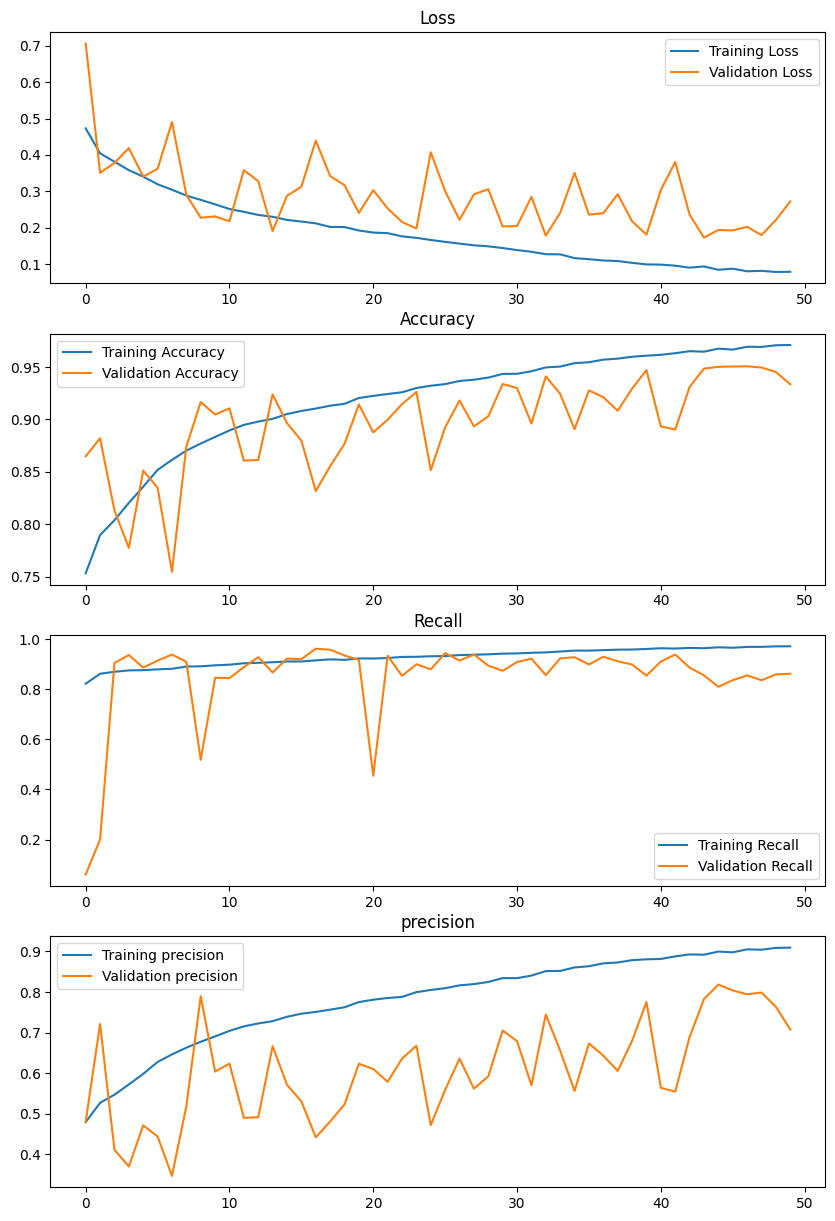

In [24]:
plot_histories([history_g.history])

In [25]:
# Print all the history data 
pd.set_option('display.max_columns', None)  # None means unlimited
pd.set_option('display.max_rows', None)  # None means unlimited

pd.DataFrame(history_g.history)

accuracy      loss  precision    recall  val_accuracy  val_loss  \
0   0.753190  0.472961   0.479717  0.822541      0.864879  0.705691   
1   0.789676  0.404309   0.527066  0.862258      0.882062  0.350713   
2   0.803828  0.381397   0.547121  0.870147      0.813200  0.377971   
3   0.820353  0.358169   0.572389  0.875703      0.777402  0.418996   
4   0.835787  0.340320   0.598436  0.876595      0.851211  0.340514   
5   0.851869  0.319334   0.627716  0.879956      0.834809  0.361642   
6   0.861430  0.304350   0.646376  0.882083      0.754621  0.490466   
7   0.870279  0.288222   0.662840  0.891137      0.874251  0.290242   
8   0.877038  0.276507   0.677381  0.891961      0.916688  0.227511   
9   0.883354  0.264220   0.690583  0.895939      0.904712  0.230949   
10  0.889527  0.251290   0.704285  0.898546      0.910570  0.217747   
11  0.894846  0.243640   0.715309  0.904171      0.860713  0.358028   
12  0.897980  0.235083   0.722444  0.905954      0.861364  0.327855   
13  0.900576  0.229955   0.728128  0.908286      0.923848  0.190803   
14  0.905198  0.221352   0.738889  0.911168      0.896511  0.287566   
15  0.908127  0.216947   0.746516  0.911305      0.879849  0.312842   
16  0.910438  0.211982   0.750815  0.915832      0.831684  0.439200   
17  0.913161  0.202158   0.756488  0.919742      0.855376  0.342040   
18  0.914949  0.201725   0.762236  0.917684      0.876725  0.316814   
19  0.920521  0.192290   0.775117  0.923515      0.914345  0.240795   
20  0.922516  0.186678   0.780944  0.923172      0.887659  0.303190   
21  0.924304  0.185035   0.785132  0.925161      0.899766  0.252848   
22  0.925982  0.176155   0.787882  0.929483      0.914606  0.215641   
23  0.930035  0.172191   0.799505  0.930032      0.926321  0.197877   
24  0.932219  0.166277   0.804940  0.932158      0.851601  0.407249   
25  0.933786  0.161094   0.809246  0.932981      0.892476  0.300143   
26  0.936778  0.156302   0.816280  0.936891      0.918120  0.221722   
27  0.937981  0.151604   0.819276  0.938195      0.893387  0.291867   
28  0.939991  0.148823   0.824577  0.939909      0.903020  0.305773   
29  0.943489  0.144084   0.834102  0.942585      0.933871  0.203348   
30  0.943632  0.138528   0.833909  0.943682      0.929966  0.204616   
31  0.946054  0.133851   0.840300  0.946015      0.896121  0.284769   
32  0.949710  0.127197   0.851297  0.947592      0.941161  0.178080   
33  0.950502  0.126755   0.851754  0.951022      0.924369  0.240862   
34  0.953763  0.116414   0.860295  0.954658      0.890784  0.350566   
35  0.954665  0.113555   0.863292  0.954726      0.927753  0.235997   
36  0.957118  0.109873   0.870420  0.956578      0.921244  0.239893   
37  0.958100  0.108451   0.872495  0.958499      0.908357  0.292026   
38  0.959889  0.103487   0.878266  0.959116      0.929445  0.217680   
39  0.960902  0.099167   0.880324  0.961243      0.947149  0.180893   
40  0.961741  0.098566   0.881246  0.964124      0.893387  0.303539   
41  0.963276  0.095660   0.887519  0.962889      0.890393  0.380494   
42  0.965207  0.090185   0.892368  0.965702      0.931008  0.235997   
43  0.964716  0.093506   0.891659  0.964261      0.948581  0.172593   
44  0.967629  0.084379   0.899369  0.968034      0.950273  0.193859   
45  0.966727  0.087489   0.897527  0.966113      0.950534  0.192501   
46  0.969434  0.080174   0.904859  0.969475      0.950794  0.202466   
47  0.969260  0.081499   0.904016  0.969749      0.949623  0.179558   
48  0.970858  0.078412   0.908420  0.971670      0.945327  0.221169   
49  0.971112  0.078781   0.909143  0.971944      0.933611  0.271903   

    val_precision  val_recall  
0        0.480620    0.060019  
1        0.721254    0.200387  
2        0.411532    0.905131  
3        0.370455    0.937076  
4        0.471679    0.886738  
5        0.444497    0.914811  
6        0.347421    0.939013  
7        0.518478    0.909971  
8        0.789396    0.518877  
9        0.604008    0.846079  
10       0.623571    0.845111 

### Inception V2/3/Dropout

In [46]:
# total updates 
len(training_data['data'])//32 # 31.5kk updates 

31587

In [32]:
# custom callback to store the metrics more often since we're updating so much with in a epoch 
from keras.callbacks import Callback

class BatchLogger(Callback):
    def __init__(self, display):
        '''
        display: Number of batches to wait before outputting loss
        '''
        self.seen = 0
        self.display = display
        self.batch_metrics = {'loss': [], 'accuracy': [], "recall":[], "precision": [],
                              'val_loss': [], 'val_accuracy': [], "val_recall":[], "val_precision": []
                              }  # adjust based on your metrics

    def on_batch_end(self, batch, logs={}):
        self.seen += 1
        if self.seen % self.display == 0:
            for k in logs: 
                if k in self.batch_metrics:
                    self.batch_metrics[k].append(logs[k])

batch_logger = BatchLogger(display=500)  # save the metrics every 100 passes. 


In [34]:

from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Dropout, Dense, Flatten, BatchNormalization, Activation, AveragePooling2D, Add, MaxPool2D, GlobalAveragePooling2D
from keras.models import Model
# from keras.applications.inception_v3 import InceptionV3 
from keras.optimizers import Adam, SGD
def inception_module_v3(x, filters:List[int], dropout_rate=0.2):
    # 1x1 convolution
    conv1x1 = Conv2D(filters[0], (1, 1), padding='same')(x)
    conv1x1 = BatchNormalization()(conv1x1)
    conv1x1 = Activation('relu')(conv1x1)

    # 3x3 convolution
    conv3x3 = Conv2D(filters[1], (1, 1), padding='same')(x)
    conv3x3 = BatchNormalization()(conv3x3)
    conv3x3 = Activation('relu')(conv3x3)
    conv3x3 = Conv2D(filters[2], (3, 3), padding='same')(conv3x3)
    conv3x3 = BatchNormalization()(conv3x3)
    conv3x3 = Activation('relu')(conv3x3)
    conv3x3 = Dropout(dropout_rate)(conv3x3)  # Dropout added

    # Factored 5x5 convolution as two 3x3 convolutions
    conv5x5 = Conv2D(filters[3], (1, 1), padding='same')(x)
    conv5x5 = BatchNormalization()(conv5x5)
    conv5x5 = Activation('relu')(conv5x5)
    conv5x5 = Conv2D(filters[4], (3, 3), padding='same')(conv5x5)
    conv5x5 = BatchNormalization()(conv5x5)
    conv5x5 = Activation('relu')(conv5x5)
    conv5x5 = Conv2D(filters[4], (3, 3), padding='same')(conv5x5)
    conv5x5 = BatchNormalization()(conv5x5)
    conv5x5 = Activation('relu')(conv5x5)
    conv5x5 = Dropout(dropout_rate)(conv5x5)  # Dropout added

    # 7x7 convolution as three 3x3 convolutions 
    conv7x7 = Conv2D( filters[5], (1,1), padding='same')(x) 
    conv7x7 = BatchNormalization()(conv7x7) 
    conv7x7 = Activation('relu')(conv7x7) 
    conv7x7 = Conv2D(filters[6], (3,3), padding='same')(x) 
    conv7x7 = BatchNormalization()(conv7x7) 
    conv7x7 = Activation('relu')(conv7x7) 
    conv7x7 = Conv2D(filters[6], (3,3), padding='same')(x) 
    conv7x7 = BatchNormalization()(conv7x7) 
    conv7x7 = Activation('relu')(conv7x7) 
    conv7x7 = Conv2D(filters[6], (3,3), padding='same')(x) 
    conv7x7 = BatchNormalization()(conv7x7) 
    conv7x7 = Activation('relu')(conv7x7) 
    conv7x7 = Dropout(dropout_rate)(conv7x7)  # Dropout added

    
    # MaxPooling with 1x1 convolution projection
    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters[7], (1, 1), padding='same')(pool_proj)
    pool_proj = BatchNormalization()(pool_proj)
    pool_proj = Activation('relu')(pool_proj)
    pool_proj = Dropout(dropout_rate)(pool_proj)  # Dropout added

    # Concatenate all the convolutions
    output = concatenate([conv1x1, conv5x5, conv3x3, conv7x7, pool_proj] )
    return output

def create_googlenet_v2()->Model:
    input_layer = Input(shape=(299, 299, 1))
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    # Adjusted filter sizes for complexity reduction
    x = inception_module_v3(x, [64, 96, 128, 16, 32, 4, 8, 32])  # Inception module 1
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = inception_module(x, [128, 64, 28, 32, 96, 64]) # Inception module 2
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = inception_module_v3(x, [64, 96, 128, 16, 32, 32])  # Inception module 1

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(1, activation='sigmoid')(x)  # Use sigmoid activation for binary classification
    model = Model(inputs=input_layer, outputs=x)
    return model

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


model_g_custom = create_googlenet_v2()
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', )
best_val_recall_checkpoint = ModelCheckpoint('./v2_best_val_recall_checkpoint.keras', monitor='val_recall', save_best_only=True)
best_val_loss_checkpoint = ModelCheckpoint('./v2_best_val_loss_checkpoint.keras', monitor='val_loss', save_best_only=True)
model_g_custom.compile(optimizer=SGD(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', Recall(name='recall'), Precision(name='precision')])

model_g_history = model_g_custom.fit(train_dataset, 
                                     validation_data=cv_dataset, 
                                     epochs=30, 
                                     callbacks=[best_val_recall_checkpoint, best_val_loss_checkpoint, early_stopping, batch_logger], 
                                    #  steps_per_epoch=steps_per_epoch,
                                    #  batch_size=batch_size,
                                     class_weight=weights_dict
                                     )
model_g_custom.save('model_g_custom.keras')


Epoch 1/30
   1975/Unknown 171s 77ms/step - accuracy: 0.6507 - loss: 0.6601 - precision: 0.3669 - recall: 0.6761

2024-05-13 01:56:16.450969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-13 01:56:16.451213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-05-13 01:56:22.047173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-13 01:56:22.047278: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is abortin

1975/1975 ━━━━━━━━━━━━━━━━━━━━ 177s 80ms/step - accuracy: 0.6508 - loss: 0.6601 - precision: 0.3669 - recall: 0.6761 - val_accuracy: 0.7753 - val_loss: 0.5335 - val_precision: 0.3395 - val_recall: 0.7096
Epoch 2/30
1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7390 - loss: 0.5360 - precision: 0.4568 - recall: 0.7411

2024-05-13 01:58:41.590656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-13 01:58:41.590763: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 144s 73ms/step - accuracy: 0.7390 - loss: 0.5360 - precision: 0.4569 - recall: 0.7411 - val_accuracy: 0.7446 - val_loss: 0.5421 - val_precision: 0.3324 - val_recall: 0.8916
Epoch 3/30


2024-05-13 01:58:45.980906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-13 01:58:45.981003: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 107516514996523445
2024-05-13 01:58:45.981044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7638 - loss: 0.4643 - precision: 0.4907 - recall: 0.8244

2024-05-13 02:01:05.908878: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-13 02:01:05.909119: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 144s 73ms/step - accuracy: 0.7638 - loss: 0.4643 - precision: 0.4907 - recall: 0.8244 - val_accuracy: 0.7669 - val_loss: 0.4661 - val_precision: 0.3581 - val_recall: 0.9255
Epoch 4/30


2024-05-13 02:01:10.271552: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-13 02:01:10.271659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-13 02:01:10.271680: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 107516514996523445
2024-05-13 02:01:10.271717: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7944063621409591695


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7811 - loss: 0.4215 - precision: 0.5130 - recall: 0.8580

2024-05-13 02:03:29.486068: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-13 02:03:29.486258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 143s 72ms/step - accuracy: 0.7811 - loss: 0.4215 - precision: 0.5131 - recall: 0.8580 - val_accuracy: 0.5070 - val_loss: 0.9245 - val_precision: 0.2142 - val_recall: 0.9990
Epoch 5/30


2024-05-13 02:03:33.790961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-13 02:03:33.791040: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 107516514996523445
2024-05-13 02:03:33.791078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7967 - loss: 0.3959 - precision: 0.5345 - recall: 0.8696

2024-05-13 02:05:55.378918: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-13 02:05:55.379004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-13 02:05:59.754500: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-13 02:05:59.754581: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 107516514996523445
2024-05-13 02:05:59.754616: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 146s 74ms/step - accuracy: 0.7967 - loss: 0.3959 - precision: 0.5345 - recall: 0.8695 - val_accuracy: 0.8680 - val_loss: 0.3435 - val_precision: 0.5115 - val_recall: 0.4076
Epoch 6/30
1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8068 - loss: 0.3814 - precision: 0.5490 - recall: 0.8718

2024-05-13 02:08:21.432764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-13 02:08:21.433050: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-13 02:08:25.821198: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-13 02:08:25.821301: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 146s 74ms/step - accuracy: 0.8068 - loss: 0.3814 - precision: 0.5490 - recall: 0.8718 - val_accuracy: 0.8750 - val_loss: 0.2922 - val_precision: 0.6515 - val_recall: 0.1520
Epoch 7/30
1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8154 - loss: 0.3725 - precision: 0.5623 - recall: 0.8722

2024-05-13 02:10:46.807682: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-13 02:10:46.807805: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 145s 73ms/step - accuracy: 0.8154 - loss: 0.3725 - precision: 0.5623 - recall: 0.8722 - val_accuracy: 0.8808 - val_loss: 0.2947 - val_precision: 0.5936 - val_recall: 0.3591
Epoch 8/30


2024-05-13 02:10:51.193605: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-13 02:10:51.193700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8173 - loss: 0.3638 - precision: 0.5655 - recall: 0.8731

2024-05-13 02:13:12.291111: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-13 02:13:12.291212: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 145s 74ms/step - accuracy: 0.8173 - loss: 0.3638 - precision: 0.5655 - recall: 0.8731 - val_accuracy: 0.6558 - val_loss: 0.7241 - val_precision: 0.2790 - val_recall: 0.9845
Epoch 9/30


2024-05-13 02:13:16.658455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-13 02:13:16.658555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8225 - loss: 0.3594 - precision: 0.5741 - recall: 0.8696

2024-05-13 02:15:37.761772: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-13 02:15:37.762090: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 146s 74ms/step - accuracy: 0.8225 - loss: 0.3594 - precision: 0.5741 - recall: 0.8696 - val_accuracy: 0.8185 - val_loss: 0.3927 - val_precision: 0.4190 - val_recall: 0.9042
Epoch 10/30


2024-05-13 02:15:42.328563: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-13 02:15:42.328650: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 107516514996523445
2024-05-13 02:15:42.328684: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8246 - loss: 0.3523 - precision: 0.5770 - recall: 0.8731

2024-05-13 02:18:01.989787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-13 02:18:01.989912: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2024-05-13 02:18:01.989970: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7944063621409591695


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 144s 73ms/step - accuracy: 0.8246 - loss: 0.3523 - precision: 0.5770 - recall: 0.8731 - val_accuracy: 0.8297 - val_loss: 0.3595 - val_precision: 0.4355 - val_recall: 0.8993
Epoch 11/30


2024-05-13 02:18:06.256211: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-13 02:18:06.256306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8267 - loss: 0.3482 - precision: 0.5802 - recall: 0.8756

2024-05-13 02:20:26.359070: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-13 02:20:26.359243: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 144s 73ms/step - accuracy: 0.8267 - loss: 0.3482 - precision: 0.5802 - recall: 0.8756 - val_accuracy: 0.8352 - val_loss: 0.3791 - val_precision: 0.4428 - val_recall: 0.8732
Epoch 12/30


2024-05-13 02:20:30.708845: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-13 02:20:30.708937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8346 - loss: 0.3414 - precision: 0.5943 - recall: 0.8767

2024-05-13 02:22:52.668696: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-13 02:22:52.668794: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 146s 74ms/step - accuracy: 0.8346 - loss: 0.3414 - precision: 0.5943 - recall: 0.8767 - val_accuracy: 0.8523 - val_loss: 0.3574 - val_precision: 0.4729 - val_recall: 0.8625
Epoch 13/30


2024-05-13 02:22:57.051684: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-13 02:22:57.051814: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8347 - loss: 0.3404 - precision: 0.5938 - recall: 0.8793

2024-05-13 02:25:18.310727: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-13 02:25:18.310854: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-13 02:25:22.788717: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-13 02:25:22.788806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 146s 74ms/step - accuracy: 0.8347 - loss: 0.3404 - precision: 0.5938 - recall: 0.8793 - val_accuracy: 0.9100 - val_loss: 0.2347 - val_precision: 0.7165 - val_recall: 0.5479
Epoch 14/30
1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8361 - loss: 0.3377 - precision: 0.5970 - recall: 0.8751

2024-05-13 02:27:44.222785: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-13 02:27:44.222888: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 146s 74ms/step - accuracy: 0.8361 - loss: 0.3377 - precision: 0.5970 - recall: 0.8751 - val_accuracy: 0.8266 - val_loss: 0.3671 - val_precision: 0.4308 - val_recall: 0.9013
Epoch 15/30


2024-05-13 02:27:48.632632: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-13 02:27:48.632713: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8383 - loss: 0.3335 - precision: 0.6003 - recall: 0.8793

2024-05-13 02:30:09.051815: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-13 02:30:09.051988: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 145s 73ms/step - accuracy: 0.8383 - loss: 0.3336 - precision: 0.6003 - recall: 0.8793 - val_accuracy: 0.8847 - val_loss: 0.2898 - val_precision: 0.5470 - val_recall: 0.8277
Epoch 16/30


2024-05-13 02:30:13.409931: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-13 02:30:13.410021: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-13 02:30:13.410043: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 107516514996523445
2024-05-13 02:30:13.410078: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7944063621409591695


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8395 - loss: 0.3314 - precision: 0.6023 - recall: 0.8802

2024-05-13 02:32:33.941891: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-13 02:32:33.942027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 145s 73ms/step - accuracy: 0.8395 - loss: 0.3314 - precision: 0.6023 - recall: 0.8802 - val_accuracy: 0.9077 - val_loss: 0.2555 - val_precision: 0.6439 - val_recall: 0.7018
Epoch 17/30


2024-05-13 02:32:38.297722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-13 02:32:38.297810: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8444 - loss: 0.3245 - precision: 0.6107 - recall: 0.8818

2024-05-13 02:34:58.492971: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-13 02:34:58.493120: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 145s 73ms/step - accuracy: 0.8444 - loss: 0.3245 - precision: 0.6107 - recall: 0.8818 - val_accuracy: 0.8841 - val_loss: 0.2717 - val_precision: 0.6092 - val_recall: 0.3863
Epoch 18/30


2024-05-13 02:35:02.878532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-13 02:35:02.878620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8451 - loss: 0.3259 - precision: 0.6127 - recall: 0.8808

2024-05-13 02:37:24.016941: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-13 02:37:24.017064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 145s 74ms/step - accuracy: 0.8451 - loss: 0.3259 - precision: 0.6127 - recall: 0.8808 - val_accuracy: 0.8994 - val_loss: 0.2574 - val_precision: 0.6071 - val_recall: 0.7135
Epoch 19/30


2024-05-13 02:37:28.373242: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-13 02:37:28.373330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-13 02:37:28.373348: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 107516514996523445
2024-05-13 02:37:28.373381: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7944063621409591695


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8480 - loss: 0.3224 - precision: 0.6186 - recall: 0.8793

2024-05-13 02:39:48.784972: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-13 02:39:48.785069: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-13 02:39:48.785088: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7944063621409591695
2024-05-13 02:39:48.785094: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3754976949919265167
2024-05-13 02:39:48.785128: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 107516514996523445


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 145s 73ms/step - accuracy: 0.8480 - loss: 0.3224 - precision: 0.6186 - recall: 0.8793 - val_accuracy: 0.7318 - val_loss: 0.5136 - val_precision: 0.3317 - val_recall: 0.9797
Epoch 20/30


2024-05-13 02:39:53.093226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-13 02:39:53.093318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8500 - loss: 0.3161 - precision: 0.6209 - recall: 0.8855

2024-05-13 02:42:14.837490: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-13 02:42:14.837578: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 146s 74ms/step - accuracy: 0.8500 - loss: 0.3161 - precision: 0.6209 - recall: 0.8855 - val_accuracy: 0.8843 - val_loss: 0.2708 - val_precision: 0.6180 - val_recall: 0.3650
Epoch 21/30


2024-05-13 02:42:19.265711: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-13 02:42:19.266140: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-13 02:42:19.266204: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 107516514996523445
2024-05-13 02:42:19.266276: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7944063621409591695


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8538 - loss: 0.3147 - precision: 0.6290 - recall: 0.8815

2024-05-13 02:44:39.675435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-13 02:44:39.675545: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7944063621409591695
2024-05-13 02:44:39.675565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 145s 73ms/step - accuracy: 0.8538 - loss: 0.3147 - precision: 0.6290 - recall: 0.8815 - val_accuracy: 0.8736 - val_loss: 0.4039 - val_precision: 0.7818 - val_recall: 0.0833
Epoch 22/30


2024-05-13 02:44:44.317883: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-13 02:44:44.317974: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8514 - loss: 0.3156 - precision: 0.6228 - recall: 0.8877

2024-05-13 02:47:06.032307: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-13 02:47:06.032398: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7944063621409591695
2024-05-13 02:47:06.032444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 146s 74ms/step - accuracy: 0.8514 - loss: 0.3156 - precision: 0.6228 - recall: 0.8877 - val_accuracy: 0.8761 - val_loss: 0.3921 - val_precision: 0.7396 - val_recall: 0.1210
Epoch 23/30


2024-05-13 02:47:10.500041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-13 02:47:10.500125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1974/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8556 - loss: 0.3116 - precision: 0.6319 - recall: 0.8874

2024-05-13 02:49:30.927227: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-13 02:49:30.927415: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1975/1975 ━━━━━━━━━━━━━━━━━━━━ 145s 73ms/step - accuracy: 0.8556 - loss: 0.3116 - precision: 0.6319 - recall: 0.8874 - val_accuracy: 0.5771 - val_loss: 0.9160 - val_precision: 0.2404 - val_recall: 0.9932


2024-05-13 02:49:35.376609: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-13 02:49:35.376694: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


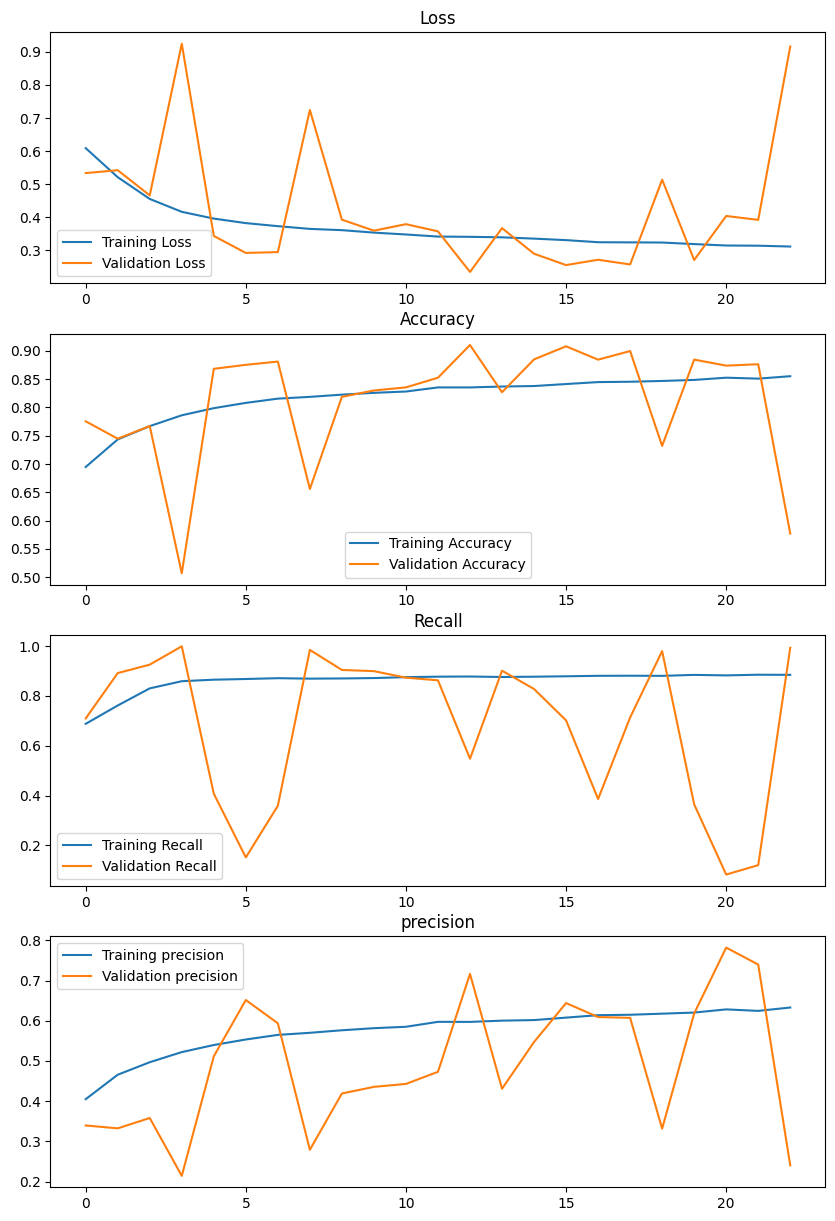

In [35]:
plot_histories([model_g_history.history ], False )

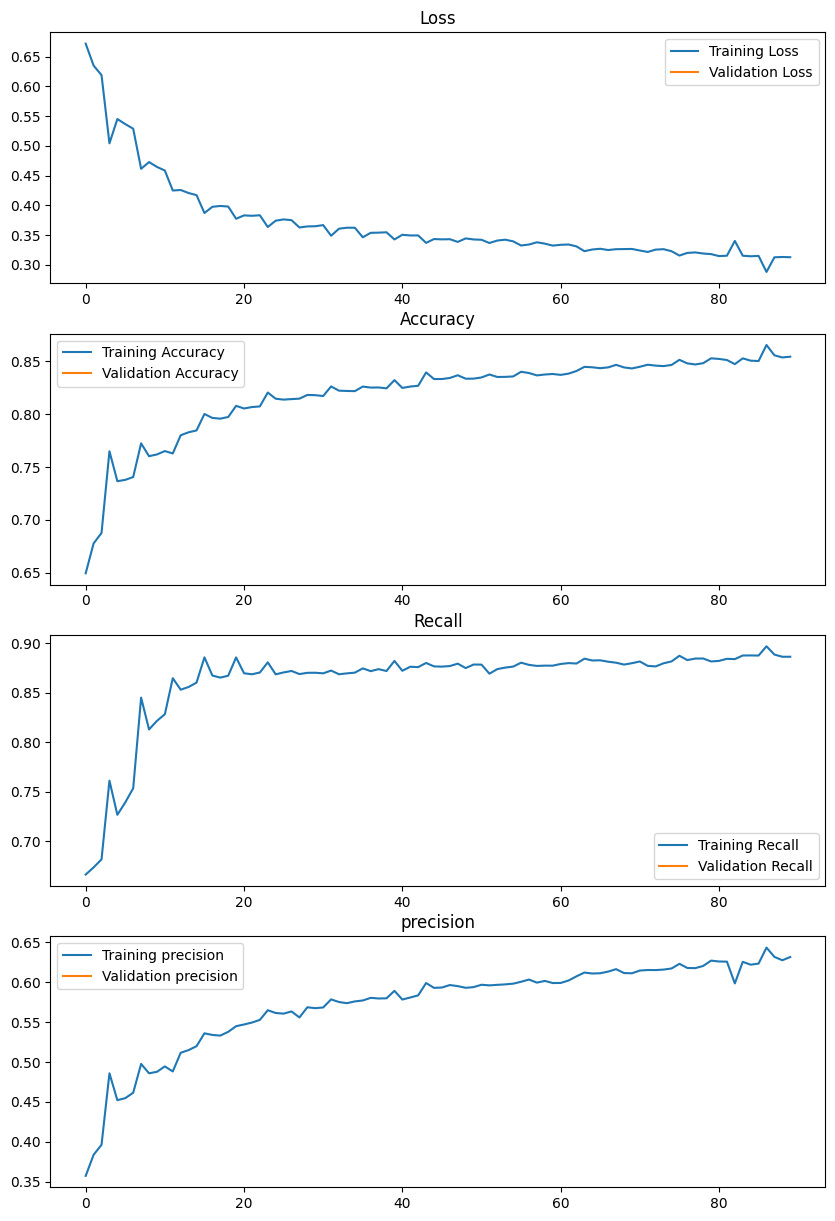

In [37]:
plot_histories([batch_logger.batch_metrics ], False )

In [38]:
batch_metrics = pd.DataFrame(batch_logger.batch_metrics)


ValueError: All arrays must be of the same length

In [ ]:
model_g_history2 = model_g_custom.fit(train_dataset, 
                                     validation_data=cv_dataset, 
                                     epochs=30, 
                                     callbacks=[best_val_recall_checkpoint, best_val_loss_checkpoint, early_stopping, batch_logger], 
                                    #  steps_per_epoch=steps_per_epoch,
                                    #  batch_size=batch_size,
                                     class_weight=weights_dict
                                     )


# Loading the test dataset
Loaded the test dataset towards the end so that we can have extra memory while training the models 

In [42]:
test_dataset = create_tf_dataset(test_data).batch(32)

# Evaluating the best model against test data

In [46]:
# latest model 
loss, accuracy,precision, recall = model_g_custom.evaluate(test_dataset)

print("Loss: ", loss) 			# 
print("Accuracy: ", accuracy) 	# 
print("Recall: ", recall) 		# 
print('Precision = ', precision)# 


241/241 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5736 - loss: 0.9356 - precision: 0.2272 - recall: 0.9953
Loss:  0.9268800616264343
Accuracy:  0.57485032081604
Recall:  0.992790937423706
Precision =  0.22827373445034027


2024-05-13 03:13:55.817739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-13 03:13:55.817808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-13 03:13:55.817825: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 107516514996523445
2024-05-13 03:13:55.817857: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7944063621409591695


In [47]:
# best model in terms of loss 
loaded_model = create_googlenet_v2()
loaded_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Recall(name='recall'), Precision(name='precision')])
loaded_model.load_weights("./v2_best_val_loss_checkpoint.keras")

loss, accuracy, precision, recall = loaded_model.evaluate(test_dataset) 

print("Loss: ", loss) 			# 0.2357979118824005
print("Accuracy: ", accuracy) 	# 0.9073157906532288
print("Recall: ", recall) 		# 0.4984551966190338
print("Precision: ", precision) # 0.6826516389846802


241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.9124 - loss: 0.2282 - precision: 0.6883 - recall: 0.5233
Loss:  0.2357979118824005
Accuracy:  0.9073157906532288
Recall:  0.4984551966190338
Precision:  0.6826516389846802


2024-05-13 03:14:13.242584: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-13 03:14:13.242675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-13 03:14:13.242699: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7944063621409591695


In [45]:
# best model in terms of recall 
loaded_model = create_googlenet_v2()
loaded_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Recall(name='recall'), Precision(name='precision')])
loaded_model.load_weights("./v2_best_val_recall_checkpoint.keras")

loss, accuracy, precision, recall = loaded_model.evaluate(test_dataset)

print("Loss: ", loss) 			#  0.38564881682395935
print("Accuracy: ", accuracy) 	# 0.8816714286804199
print("Recall: ", recall) 		# 0.08032955974340439
print("Precision: ", precision) # 0.8297872543334961


241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8821 - loss: 0.3797 - precision: 0.8672 - recall: 0.0673
Loss:  0.38564881682395935
Accuracy:  0.8816714286804199
Recall:  0.08032955974340439
Precision:  0.8297872543334961


2024-05-13 03:12:49.103138: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-13 03:12:49.103226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-13 03:12:49.103268: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7944063621409591695
2024-05-13 03:12:49.103310: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 107516514996523445
